In [15]:
# import libraries

import numpy as np
import pandas as pd
from sklearn.datasets import load_files
from glob import glob
from tqdm import tqdm
from os.path import join
from keras.preprocessing import image
from PIL import ImageFile
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint 
from keras.utils import np_utils
from keras.applications.inception_v3 import InceptionV3
from keras import Model
import time
import matplotlib.pyplot as plt

In [3]:
# Load data
train_data_folder = './files/train'
test_data_folder = './files/test'

# function to load the train data
def load_train_data(path):
    data = load_files(path)
    obj_files = np.array(data['filenames'])
    obj_targets = np_utils.to_categorical(np.array(data['target']), 12)    # 3 --> currently: number of categories
    return obj_files, obj_targets

# load train dataset
train_files, train_targets = load_train_data('./files/train')

# load list of objects
obj_names = [item[14:-1] for item in sorted(glob("./files/train/*/"))]
num_obj = len(obj_names)

# print dataset statistics
print('There are %d number of categories.' % len(obj_names))
print('There are %d number of images.' % len(train_files))

There are 12 number of categories.
There are 1444 number of images.


In [4]:
# train_targets
obj_names

['banana',
 'broccoli',
 'cabbage',
 'capsicum',
 'eggplant',
 'grapes',
 'mushroom',
 'onion',
 'orange',
 'peas',
 'potato',
 'tomato']

In [8]:
# Pre-process the Data 
# converting images into 4D Tensors in the form of (no of samples, rows, columns, channels) 
# as required by Keras using Tensorflow as backend
# channels = 3 for RGB images

# Set target of images 
image_width, image_height = 256, 256

def image_to_tensor_format(input_image):
    img = image.load_img(input_image, target_size=(image_width, image_height))
    # convert image to 3D tensor of form (224, 224, 3)
    image_tensor = image.img_to_array(img)
    # converting 3D tensor to 4D tensor as required by keras as (1, 224, 224, 3) and return
    # no of samples = 1 as for a single image
    return np.expand_dims(image_tensor, axis=0)

def train_to_tensor(image_path):
    tensor_list = [image_to_tensor_format(img) for img in tqdm(image_path)]
    return np.vstack(tensor_list)          # Stack arrays in sequence vertically (row wise)

In [9]:
# preprocessing - rescaling images by dividing all pixels by 255
# normalising the values from 0-1
ImageFile.LOAD_TRUNCATED_IMAGES = True     # for error handling while reading images

train_data = train_to_tensor(train_files).astype('float32')/255

100%|██████████| 1444/1444 [00:07<00:00, 184.56it/s]


### Basic CNN Model using Keras

In [46]:
# CNN Model -- basic with only Keras (no pre-trained model)

model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (3,3), strides = (2,2), padding = 'valid', activation = 'relu', 
          input_shape = (image_width, image_height, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='valid'))
model.add(Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='valid'))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
model.add(AveragePooling2D(pool_size=(3, 3), strides=None, padding='valid'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(108, activation='sigmoid'))
model.add(Dense(num_obj, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 127, 127, 8)       224       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 42, 42, 8)         0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 40, 40, 16)        1168      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
average_pooling2d_23 (Averag (None, 3, 3, 32)          0         
__________

In [47]:
# Compiling the model 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
# Training the model

# number of epochs to train the model
# one epoch = one forward pass and one backward pass of all the training examples
t0 = time.time()
epochs = 50

# checkpoints to save model with minimum loss
checkpoints = ModelCheckpoint(filepath='./chkpoints/checkpoints_with_best_loss_v3.hdf5', 
                               verbose=1, save_best_only=True)

# model.load_weights('./chkpoints/checkpoints_with_best_loss.hdf5')

base_history = model.fit(train_data, train_targets, validation_split=0.2, epochs=epochs, batch_size=20, 
          callbacks=[checkpoints], verbose=1)
t1 = time.time()                         
print "Total time taken: {0}min".format((t1-t0) / 60)

Train on 1155 samples, validate on 289 samples
Epoch 1/50
1155/1155 [==============================] - 15s 13ms/step - loss: 2.4506 - acc: 0.1273 - val_loss: 2.2122 - val_acc: 0.1592
Epoch 2/50
1155/1155 [==============================] - 13s 11ms/step - loss: 2.0292 - acc: 0.2502 - val_loss: 1.9007 - val_acc: 0.3010
Epoch 3/50
1155/1155 [==============================] - 13s 11ms/step - loss: 1.7514 - acc: 0.3429 - val_loss: 1.5769 - val_acc: 0.4221
Epoch 4/50
1155/1155 [==============================] - 13s 11ms/step - loss: 1.5387 - acc: 0.4329 - val_loss: 1.3587 - val_acc: 0.5121
Epoch 5/50
1155/1155 [==============================] - 13s 11ms/step - loss: 1.4503 - acc: 0.4571 - val_loss: 1.2553 - val_acc: 0.4948
Epoch 6/50
1155/1155 [==============================] - 13s 11ms/step - loss: 1.3237 - acc: 0.4987 - val_loss: 1.1386 - val_acc: 0.5813
Epoch 7/50
1155/1155 [==============================] - 13s 11ms/step - loss: 1.2761 - acc: 0.5169 - val_loss: 1.1714 - val_acc: 0.5606
E

Epoch 28/50
1155/1155 [==============================] - 13s 11ms/step - loss: 0.7566 - acc: 0.7108 - val_loss: 0.8128 - val_acc: 0.7405
Epoch 29/50
1155/1155 [==============================] - 13s 11ms/step - loss: 0.7199 - acc: 0.7281 - val_loss: 0.8555 - val_acc: 0.7405
Epoch 30/50
1155/1155 [==============================] - 13s 11ms/step - loss: 0.7076 - acc: 0.7333 - val_loss: 0.8862 - val_acc: 0.7163
Epoch 31/50
1155/1155 [==============================] - 13s 11ms/step - loss: 0.7282 - acc: 0.7195 - val_loss: 0.8431 - val_acc: 0.7301
Epoch 32/50
1155/1155 [==============================] - 13s 11ms/step - loss: 0.6982 - acc: 0.7437 - val_loss: 0.8075 - val_acc: 0.7647
Epoch 33/50
1155/1155 [==============================] - 13s 11ms/step - loss: 0.6934 - acc: 0.7463 - val_loss: 0.8719 - val_acc: 0.7197
Epoch 34/50
1155/1155 [==============================] - 13s 11ms/step - loss: 0.6699 - acc: 0.7481 - val_loss: 0.8888 - val_acc: 0.7128
Epoch 35/50
1155/1155 [==================

In [49]:
print(base_history.history.keys()) 

['acc', 'loss', 'val_acc', 'val_loss']


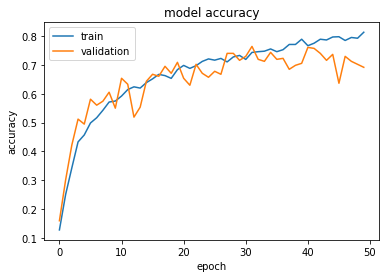

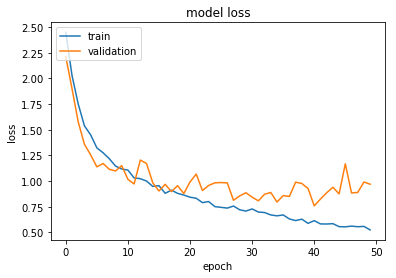

In [50]:
#  "Accuracy"
plt.plot(base_history.history['acc'])
plt.plot(base_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(base_history.history['loss'])
plt.plot(base_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [51]:
# Load model weights with best validation loss.
model.load_weights('./chkpoints/checkpoints_with_best_loss_v3.hdf5')

In [52]:
import matplotlib.image as mpimg

top_n = 3

def predict_obj(path):
    
    # load image and convert to 4D tensor
    print('Loading image...')
    image_tensor = image_to_tensor_format(path).astype('float32')/255

    # feed into top_model for obj prediction
    image_prediction = model.predict(image_tensor, batch_size=32, verbose=1)[0]
    obj_predicted = [obj_names[idx] for idx in np.argsort(image_prediction)[::-1][:top_n]]
    confidence_predicted = np.sort(image_prediction)[::-1][:top_n]
    
    return obj_predicted, confidence_predicted


def make_prediction(path):
    obj, confidence = predict_obj(path)
    img = mpimg.imread(path)
    plt.axis('off')
    imgplot = plt.imshow(img)
    plt.show(imgplot)
    print('\nTop 3 predictions:')
    for i, j in zip(obj, confidence):
        print('Predicted obj: {} with a confidence of {:.4f}'.format(i.replace("_", " "), j))

Loading image...
1/1 [==============================] - 0s 141ms/step


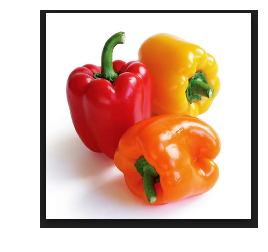


Top 3 predictions:
Predicted obj: capsicum with a confidence of 0.7596
Predicted obj: tomato with a confidence of 0.1725
Predicted obj: orange with a confidence of 0.0582


In [53]:
make_prediction('./files/test/capsicum.jpeg')

Loading image...
1/1 [==============================] - 0s 9ms/step


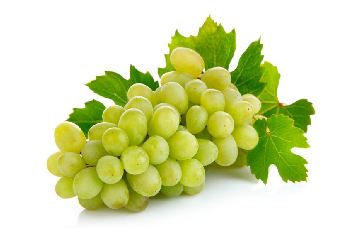


Top 3 predictions:
Predicted obj: grapes with a confidence of 0.8891
Predicted obj: banana with a confidence of 0.0450
Predicted obj: peas with a confidence of 0.0334


In [54]:
make_prediction('./files/test/grapes1.jpg')

Loading image...
1/1 [==============================] - 0s 13ms/step


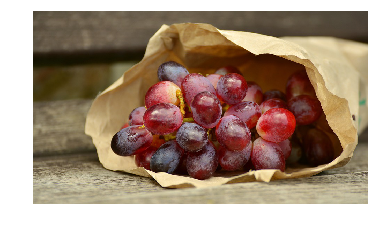


Top 3 predictions:
Predicted obj: grapes with a confidence of 0.7530
Predicted obj: onion with a confidence of 0.1508
Predicted obj: mushroom with a confidence of 0.0793


In [55]:
make_prediction('./files/test/grapes.jpg')

Loading image...
1/1 [==============================] - 0s 7ms/step


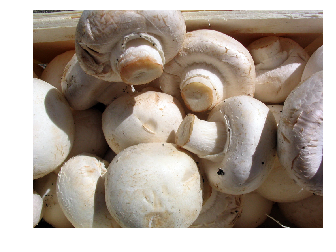


Top 3 predictions:
Predicted obj: mushroom with a confidence of 0.9699
Predicted obj: eggplant with a confidence of 0.0109
Predicted obj: onion with a confidence of 0.0096


In [56]:
make_prediction('./files/test/mushroom.jpg')

Loading image...
1/1 [==============================] - 0s 12ms/step


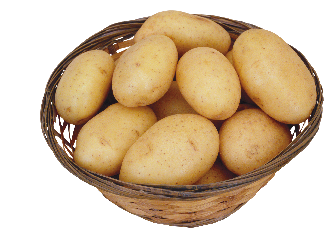


Top 3 predictions:
Predicted obj: potato with a confidence of 0.8102
Predicted obj: banana with a confidence of 0.0717
Predicted obj: onion with a confidence of 0.0599


In [57]:
make_prediction('./files/test/potato.png')

Loading image...
1/1 [==============================] - 0s 11ms/step


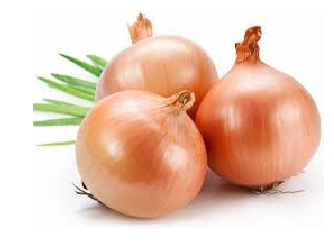


Top 3 predictions:
Predicted obj: onion with a confidence of 0.8750
Predicted obj: potato with a confidence of 0.1106
Predicted obj: mushroom with a confidence of 0.0050


In [60]:
make_prediction('./files/test/onion1.jpeg')